## DNN_for_Regression 

In [13]:
from __future__ import absolute_import, division, print_function

import pathlib

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

print(tf.__version__)
pd.set_option("display.width",1000)

1.12.0


### 准备数据集 

In [3]:
dataset_path = keras.utils.get_file("auto-mpg.data", "https://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data")
dataset_path

32768/30286 [================================] - 1s 32us/step


'C:\\Users\\vendanner\\AppData\\Roaming\\SPB_Data\\.keras\\datasets\\auto-mpg.data'

In [25]:
column_names = ['MPG','Cylinders','Displacement','Horsepower','Weight',
                'Acceleration', 'Model Year', 'Origin'] 
raw_dataset = pd.read_csv(dataset_path, names=column_names,na_values = "?", comment='\t',sep=" ", skipinitialspace=True)
dataset = raw_dataset.copy()

In [26]:
print(dataset.head())

    MPG  Cylinders  Displacement  Horsepower  Weight  Acceleration  Model Year  Origin
0  18.0          8         307.0       130.0  3504.0          12.0          70       1
1  15.0          8         350.0       165.0  3693.0          11.5          70       1
2  18.0          8         318.0       150.0  3436.0          11.0          70       1
3  16.0          8         304.0       150.0  3433.0          12.0          70       1
4  17.0          8         302.0       140.0  3449.0          10.5          70       1


### 清洗数据 

In [27]:
dataset.isna().sum()
# 发现 Horsepower 列有6个空数据，删除空数据
dataset = dataset.dropna()
# 已删除6个数据，当前无空数据的样本
dataset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 392 entries, 0 to 397
Data columns (total 8 columns):
MPG             392 non-null float64
Cylinders       392 non-null int64
Displacement    392 non-null float64
Horsepower      392 non-null float64
Weight          392 non-null float64
Acceleration    392 non-null float64
Model Year      392 non-null int64
Origin          392 non-null int64
dtypes: float64(5), int64(3)
memory usage: 27.6 KB


In [28]:
# "Origin" 列 变成独热向量
# 注意 pop 会直接移除 "Origin" 列值
origin = dataset.pop("Origin")
print(set(origin))

dataset['USA'] = (origin == 1)*1.0
dataset['Europe'] = (origin == 2)*1.0
dataset['Japan'] = (origin == 3)*1.0
# 增加 'USA'、'Europe'、'Japan' 列
print(dataset.head())

{1, 2, 3}
    MPG  Cylinders  Displacement  Horsepower  Weight  Acceleration  Model Year  USA  Europe  Japan
0  18.0          8         307.0       130.0  3504.0          12.0          70  1.0     0.0    0.0
1  15.0          8         350.0       165.0  3693.0          11.5          70  1.0     0.0    0.0
2  18.0          8         318.0       150.0  3436.0          11.0          70  1.0     0.0    0.0
3  16.0          8         304.0       150.0  3433.0          12.0          70  1.0     0.0    0.0
4  17.0          8         302.0       140.0  3449.0          10.5          70  1.0     0.0    0.0


### 划分训练和测试数据 

In [31]:
# 80% 数据划分为训练数据
train_dataset = dataset.sample(frac=0.8,random_state=0)
test_dataset = dataset.drop(train_dataset.index)

In [ ]:
# 观察数据
sns.pairplot(train_dataset[["MPG", "Cylinders", "Displacement", "Weight"]], diag_kind="kde")

In [33]:
train_stats = train_dataset.describe()
train_stats.pop("MPG")
train_stats = train_stats.transpose()
print(train_stats)
# 各列之间的数值差异挺大，需要做归一化处理

              count         mean         std     min      25%     50%      75%     max
Cylinders     314.0     5.477707    1.699788     3.0     4.00     4.0     8.00     8.0
Displacement  314.0   195.318471  104.331589    68.0   105.50   151.0   265.75   455.0
Horsepower    314.0   104.869427   38.096214    46.0    76.25    94.5   128.00   225.0
Weight        314.0  2990.251592  843.898596  1649.0  2256.50  2822.5  3608.00  5140.0
Acceleration  314.0    15.559236    2.789230     8.0    13.80    15.5    17.20    24.8
Model Year    314.0    75.898089    3.675642    70.0    73.00    76.0    79.00    82.0
USA           314.0     0.624204    0.485101     0.0     0.00     1.0     1.00     1.0
Europe        314.0     0.178344    0.383413     0.0     0.00     0.0     0.00     1.0
Japan         314.0     0.197452    0.398712     0.0     0.00     0.0     0.00     1.0


In [34]:
# 取出标签值 并生成训练数据集
train_label = train_dataset.pop("MPG")
test_label = test_dataset.pop("MPG")


#### 归一化 

In [36]:
# 使用标准化
def norm(x):
    return (x - train_stats["mean"])/train_stats["std"]

normed_train_data = norm(train_dataset)
normed_test_data = norm(test_dataset)

## 模型 

In [37]:
def build_model():
    model = keras.Sequential([
        keras.layers.Dense(64,activation=tf.nn.relu,input_shape=[len(train_dataset.keys())]),
        keras.layers.Dense(64,activation=tf.nn.relu),
        keras.layers.Dense(1)
    ])
    # 除了均方误差，还有百分比的均方误差，对于数值差异较大的回归，增加百分比更有说服力
    model.compile(loss="mean_squared_error",
                 optimizer=keras.optimizers.RMSprop(),
                 metrics=['mean_absolute_error', 'mean_squared_error'])
    
    return model

In [38]:
model = build_model()

### 检查模型 

In [39]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 64)                640       
_________________________________________________________________
dense_1 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 65        
Total params: 4,865
Trainable params: 4,865
Non-trainable params: 0
_________________________________________________________________


### 训练模型 

In [40]:
class PrintDot(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs):
        if epoch % 100 == 0: print('')
        print('.', end='')

EPOCHS = 1000
# 验证集可以传入数据 或者 占比 ; verbose：日志显示
history = model.fit(normed_train_data,train_label,validation_split=0.2,epochs=EPOCHS,verbose=0,callbacks=[PrintDot()])



....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
..........................................................................................

### 展示模型结果 

In [41]:
hist = pd.DataFrame(history.history)
hist['epochs'] = history.epoch
print(hist.head())
print(hist.tail())

     val_loss  val_mean_absolute_error  val_mean_squared_error        loss  mean_absolute_error  mean_squared_error  epochs
0  575.332201                22.784150              575.332201  587.314273            23.047071          587.314273       0
1  523.281748                21.653865              523.281748  535.264694            21.919336          535.264694       1
2  470.577068                20.463769              470.577068  488.618666            20.884077          488.618666       2
3  415.433770                19.149941              415.433770  439.502594            19.752846          439.502594       3
4  357.306046                17.661665              357.306046  387.880837            18.480627          387.880837       4
     val_loss  val_mean_absolute_error  val_mean_squared_error      loss  mean_absolute_error  mean_squared_error  epochs
995  8.501222                 2.297265                8.501222  2.143668             0.861848            2.143668     995
996  8.59070

#### 图表展示 

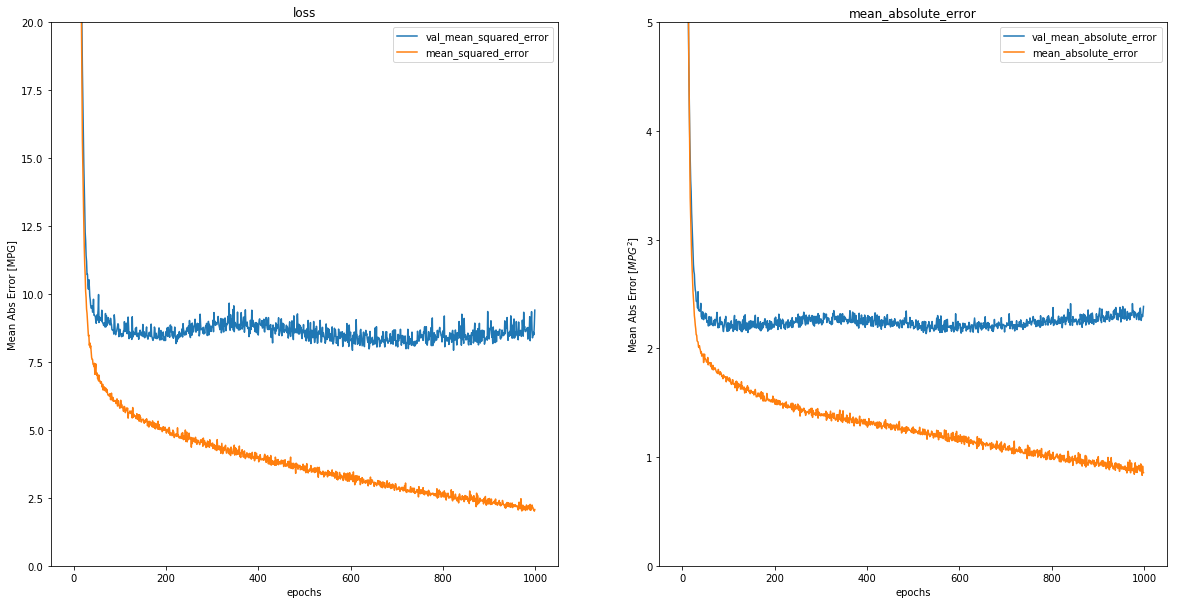

In [46]:
def plot_history():

    plt.figure(figsize=(20,10))
    plt.subplot(1,2,1)
    plt.ylim([0,20])
    plt.xlabel("epochs")
    plt.ylabel("Mean Abs Error [MPG]")
    plt.plot(hist['epochs'],hist['val_mean_squared_error'],label='val_mean_squared_error')
    plt.plot(hist['epochs'],hist['mean_squared_error'],label='mean_squared_error')
    plt.title("loss")
    plt.legend()
    
    plt.subplot(1,2,2)
    plt.ylim([0,5])
    plt.xlabel("epochs")
    plt.ylabel("Mean Abs Error [$MPG^2$]")
    plt.plot(hist['epochs'],hist['val_mean_absolute_error'],label='val_mean_absolute_error')
    plt.plot(hist['epochs'],hist['mean_absolute_error'],label='mean_absolute_error')
    plt.title("mean_absolute_error")
    plt.legend()
    
    plt.show()
    
plot_history()

### 优化模型 


...............................................................

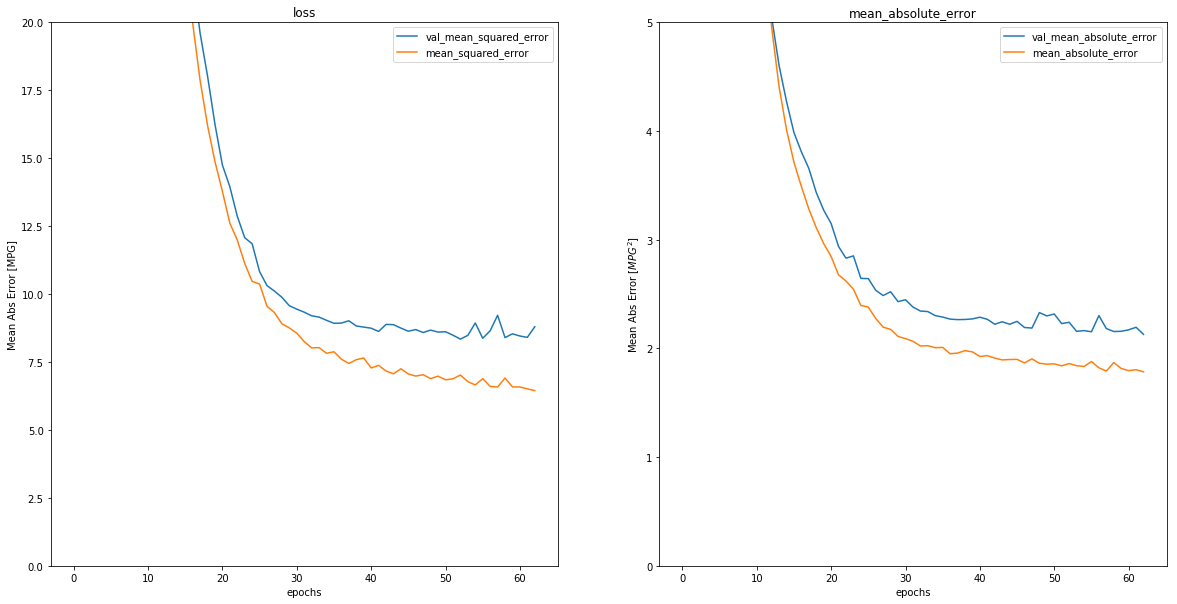

In [48]:
# 上图训练结果表示，在训练100之后，验证集的损失误差下降就不明显
# 基于此，我们可以指定规则，让训练提早结束 - 不能降低误差后

model = build_model()
# 当 在 10 epochs 后性能没有提升，则提早退出
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss',patience=10)
history = model.fit(normed_train_data,train_label,validation_split=0.2,epochs=EPOCHS,verbose=0,callbacks=[early_stop,PrintDot()])
hist = pd.DataFrame(history.history)
hist['epochs'] = history.epoch

plot_history()
# 提早结束了

### 评估模型

In [51]:
loss,mae,mse = model.evaluate(normed_test_data,test_label,verbose=0)
# 测试集评估结果
print("mae = ",mae)

mae =  2.045166003398406


#### 预测  

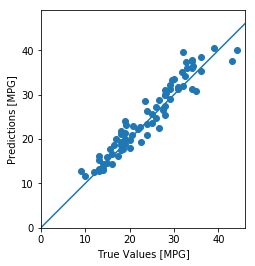

In [54]:
test_predictions = model.predict(normed_test_data).flatten()

plt.scatter(test_label,test_predictions)
plt.xlabel('True Values [MPG]')
plt.ylabel('Predictions [MPG]')
plt.axis('equal')
plt.axis('square')
plt.xlim([0,plt.xlim()[1]])
plt.ylim([0,plt.ylim()[1]])
_ = plt.plot([-100, 100], [-100, 100])

# 看到 scatter(test_label,test_predictions) 点是集中在 y=x 线上，说明预测值误差不大
# 但不可否认右上角几个点偏离有点厉害

Text(0, 0.5, 'Count')

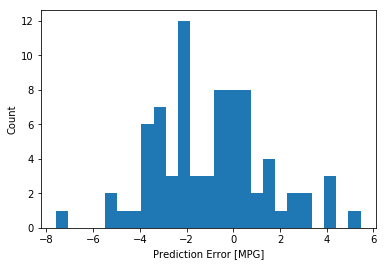

In [55]:
# 绘制错误偏离柱图

error = test_label - test_predictions
plt.hist(error,bins=25)
plt.xlabel("Prediction Error [MPG]")
plt.ylabel("Count")